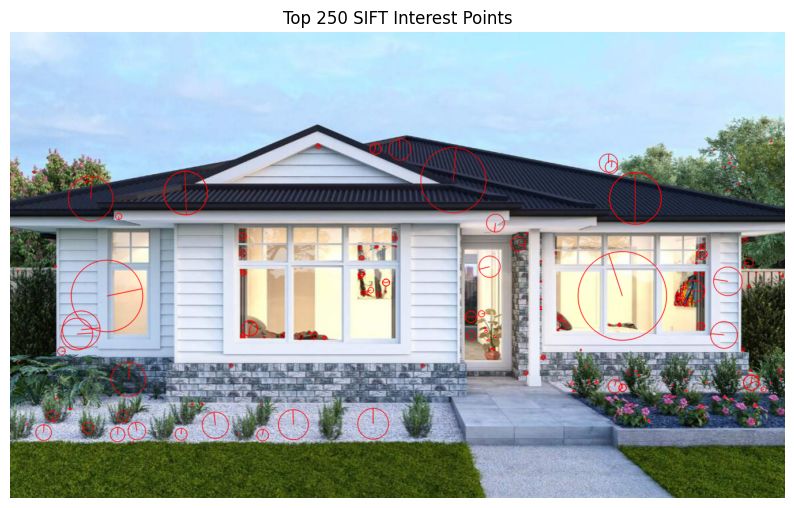

In [ ]:
#task1 : Interest point detection

import cv2
import numpy as np
import matplotlib.pyplot as plt

image_path = 'house.jpg'
image = cv2.imread(image_path)

gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

sift = cv2.SIFT_create()

keypoints, descriptors = sift.detectAndCompute(gray, None)

keypoints = sorted(keypoints, key=lambda x: -x.response)

N = 250
keypoints = keypoints[:N]

output = cv2.drawKeypoints(image, keypoints, None, color=(0, 0, 255), flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

plt.figure(figsize=(10, 8))
plt.imshow(cv2.cvtColor(output, cv2.COLOR_BGR2RGB))
plt.title(f"Top {N} SIFT Interest Points")
plt.axis("off")
plt.show()


📤 Please upload one image...


Saving house.jpg to house (1).jpg


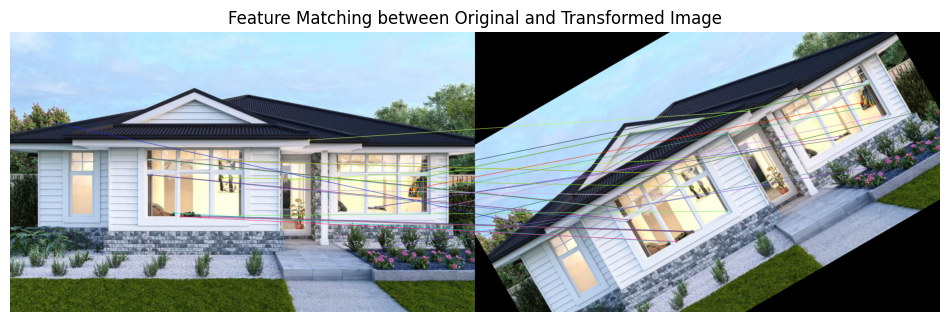

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from google.colab import files


print("📤 Please upload one image...")
uploaded = files.upload()
filename = list(uploaded.keys())[0]


img = cv2.imread(filename)
if img is None:
    raise FileNotFoundError(f"Image not found or failed to load: {filename}")


gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)


angle = 30  # Rotate by 30 degrees
(h, w) = img.shape[:2]
center = (w // 2, h // 2)
matrix = cv2.getRotationMatrix2D(center, angle, 1.0)
transformed_img = cv2.warpAffine(img, matrix, (w, h))

# Convert the transformed image to grayscale
transformed_gray = cv2.cvtColor(transformed_img, cv2.COLOR_BGR2GRAY)

# Step 1: Detect keypoints and descriptors using ORB
orb = cv2.ORB_create()

# Detect keypoints and descriptors on the original and transformed images
kp1, des1 = orb.detectAndCompute(gray, None)
kp2, des2 = orb.detectAndCompute(transformed_gray, None)

# Step 2: Match the features using BFMatcher
bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
matches = bf.match(des1, des2)
matches = sorted(matches, key=lambda x: x.distance)

# Step 3: Draw the matches between the original and transformed images
img_matches = cv2.drawMatches(img, kp1, transformed_img, kp2, matches[:30], None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

# Show the result
plt.figure(figsize=(12, 6))
plt.imshow(cv2.cvtColor(img_matches, cv2.COLOR_BGR2RGB))
plt.title("Feature Matching between Original and Transformed Image")
plt.axis('off')
plt.show()


📤 Please upload one image...


Saving cars2.jpg to cars2.jpg


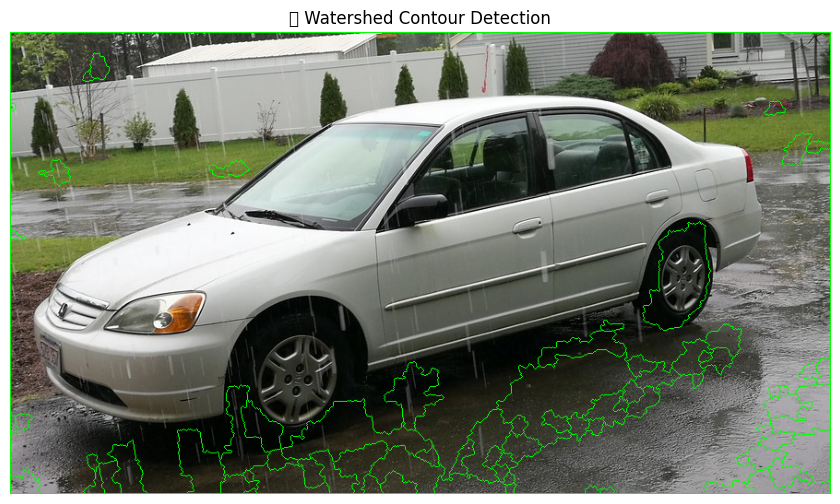

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from google.colab import files

# Upload a single image
print("📤 Please upload one image...")
uploaded = files.upload()
filename = list(uploaded.keys())[0]

# Read the image
img = cv2.imread(filename)
if img is None:
    raise FileNotFoundError(f"Image not found or failed to load: {filename}")

# Convert to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# Step 1: Canny Edge Detection
edges = cv2.Canny(gray, 100, 200)

# Step 2: Dilation
kernel = np.ones((3, 3), np.uint8)
edges_dilated = cv2.dilate(edges, kernel, iterations=1)

# Step 3: Gaussian Blur + Threshold
blurred = cv2.GaussianBlur(edges_dilated, (5, 5), 0)
_, binary = cv2.threshold(blurred, 50, 255, cv2.THRESH_BINARY)

# Step 4: Find Contours and Fill
contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
markers = np.zeros_like(gray)
cv2.drawContours(markers, contours, -1, 255, thickness=cv2.FILLED)

# Step 5: Watershed Segmentation
_, markers_labels = cv2.connectedComponents(markers.astype(np.uint8))
img_ws = img.copy()
markers_ws = cv2.watershed(img_ws, markers_labels)

# Highlight watershed boundaries in green
img_ws[markers_ws == -1] = [0, 255, 0]

# Show final result
plt.figure(figsize=(12, 6))
plt.imshow(cv2.cvtColor(img_ws, cv2.COLOR_BGR2RGB))
plt.title("🧠 Watershed Contour Detection")
plt.axis('off')
plt.show()


In [ ]:
import time
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
from torchvision import models

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Transformations
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Load CIFAR-100 Dataset
trainset = torchvision.datasets.CIFAR100(root='./data', train=True, download=True, transform=transform)
testset = torchvision.datasets.CIFAR100(root='./data', train=False, download=True, transform=transform)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False, num_workers=2)

# Define training function
def train_model(model, epochs=3):
    model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    for epoch in range(epochs):
        running_loss = 0.0
        for images, labels in trainloader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        avg_loss = running_loss / len(trainloader)
        print(f"Epoch {epoch+1}, Loss: {avg_loss:.4f}")

# Evaluation function
def evaluate_model(model):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for images, labels in testloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (preds == labels).sum().item()
    accuracy = 100 * correct / total
    return accuracy

# Load ResNet18
resnet18 = models.resnet18(pretrained=True)
resnet18.fc = nn.Linear(resnet18.fc.in_features, 100)

# Load ResNet34
resnet34 = models.resnet34(pretrained=True)
resnet34.fc = nn.Linear(resnet34.fc.in_features, 100)

# Training and evaluation for ResNet18
print("\nTraining ResNet18...")
train_model(resnet18)
acc18 = evaluate_model(resnet18)

# Training and evaluation for ResNet34
print("\nTraining ResNet34...")
train_model(resnet34)
acc34 = evaluate_model(resnet34)

# Comparison of accuracy
print(f"\nComparison:\nResNet18 Accuracy: {acc18:.2f}%\nResNet34 Accuracy: {acc34:.2f}%")


100%|██████████| 169M/169M [00:06<00:00, 28.0MB/s]
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 140MB/s]
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weig


Training ResNet18...
Epoch 1, Loss: 2.9052
Epoch 2, Loss: 2.1319
Epoch 3, Loss: 1.7836

Training ResNet34...
Epoch 1, Loss: 3.1437
Epoch 2, Loss: 2.3568
Epoch 3, Loss: 2.1599

Comparison:
ResNet18 Accuracy: 46.72%
ResNet34 Accuracy: 45.66%


In [ ]:
# task 2.1: Optimized ResNet Training

import time
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
from torchvision import models

# Device config
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# CIFAR-100 recommended normalization
mean = (0.5071, 0.4867, 0.4408)
std = (0.2675, 0.2565, 0.2761)

# Data augmentation + normalization
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
])

# Load dataset
trainset = torchvision.datasets.CIFAR100(root='./data', train=True, download=True, transform=transform_train)
testset = torchvision.datasets.CIFAR100(root='./data', train=False, download=True, transform=transform_test)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(testset, batch_size=100, shuffle=False, num_workers=2)

# Training function
def train_model(model, epochs=8):
    model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for images, labels in trainloader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        scheduler.step()
        avg_loss = running_loss / len(trainloader)
        print(f"Epoch {epoch+1}/{epochs} | Loss: {avg_loss:.4f}")
    return model

# Evaluation
def evaluate_model(model):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for images, labels in testloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    acc = 100 * correct / total
    print(f"Accuracy: {acc:.2f}%")
    return acc

# Prepare ResNet18
resnet18 = models.resnet18(pretrained=True)
resnet18.fc = nn.Sequential(
    nn.Dropout(0.5),
    nn.Linear(resnet18.fc.in_features, 100)
)

# Prepare ResNet34
resnet34 = models.resnet34(pretrained=True)
resnet34.fc = nn.Sequential(
    nn.Dropout(0.5),
    nn.Linear(resnet34.fc.in_features, 100)
)

print("\nTraining ResNet18...")
model18 = train_model(resnet18)
acc18 = evaluate_model(model18)

print("\nTraining ResNet34...")
model34 = train_model(resnet34)
acc34 = evaluate_model(model34)

print(f"\nComparison:\nResNet18 Accuracy: {acc18:.2f}%\nResNet34 Accuracy: {acc34:.2f}%")



Training ResNet18...
Epoch 1/8 | Loss: 3.2088
Epoch 2/8 | Loss: 2.3638
Epoch 3/8 | Loss: 2.1224
Epoch 4/8 | Loss: 1.9782
Epoch 5/8 | Loss: 1.8905
Epoch 6/8 | Loss: 1.8387
Epoch 7/8 | Loss: 1.7884
Epoch 8/8 | Loss: 1.8230
Accuracy: 49.86%

Training ResNet34...
Epoch 1/8 | Loss: 3.9744
Epoch 2/8 | Loss: 3.2106
Epoch 3/8 | Loss: 2.5903
Epoch 4/8 | Loss: 2.3093
Epoch 5/8 | Loss: 2.1253
Epoch 6/8 | Loss: 1.9948
Epoch 7/8 | Loss: 1.9345
Epoch 8/8 | Loss: 1.8475
Accuracy: 47.71%

Comparison:
ResNet18 Accuracy: 49.86%
ResNet34 Accuracy: 47.71%
